### Funnel

In [1]:
import jax
import jax.scipy.stats as jst
from jax.random import PRNGKey, normal, split
import matplotlib.pyplot as plt
import numpy as np
from blackjax.diagnostics import effective_sample_size

from kernels import kernel_factory
from utils import *
from integrators import *
from test_functions import neg_log_funnel, neg_log_nD_funnel

root_seed=12387593871
key = PRNGKey(root_seed)

U = neg_log_nD_funnel()
# U = neg_log_funnel()
dim = 2

# key, split_key = split(key)
# q_init = normal(split_key, (dim, ))
q_init = jnp.zeros(dim)
q_init = q_init.at[-1].set(10)

2023-03-25 17:54:34.766985: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 17:54:34.961301: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 17:54:34.962763: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 17:54:36.427394: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-25 17:54:36.427442: W external/org

In [2]:
num_warmup = 1000
num_samples = 20000
keys = split(key, num=num_samples+num_warmup)

### M=1

In [3]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m1hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_m1hmc_states = jax.lax.scan(m1hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m1hmc_states = jax.lax.scan(m1hmc_kernel, carry, keys[num_warmup:,:])

Mean: 3.853583812713623+/- -0.07010771334171295
ESS: 76.31915283203125


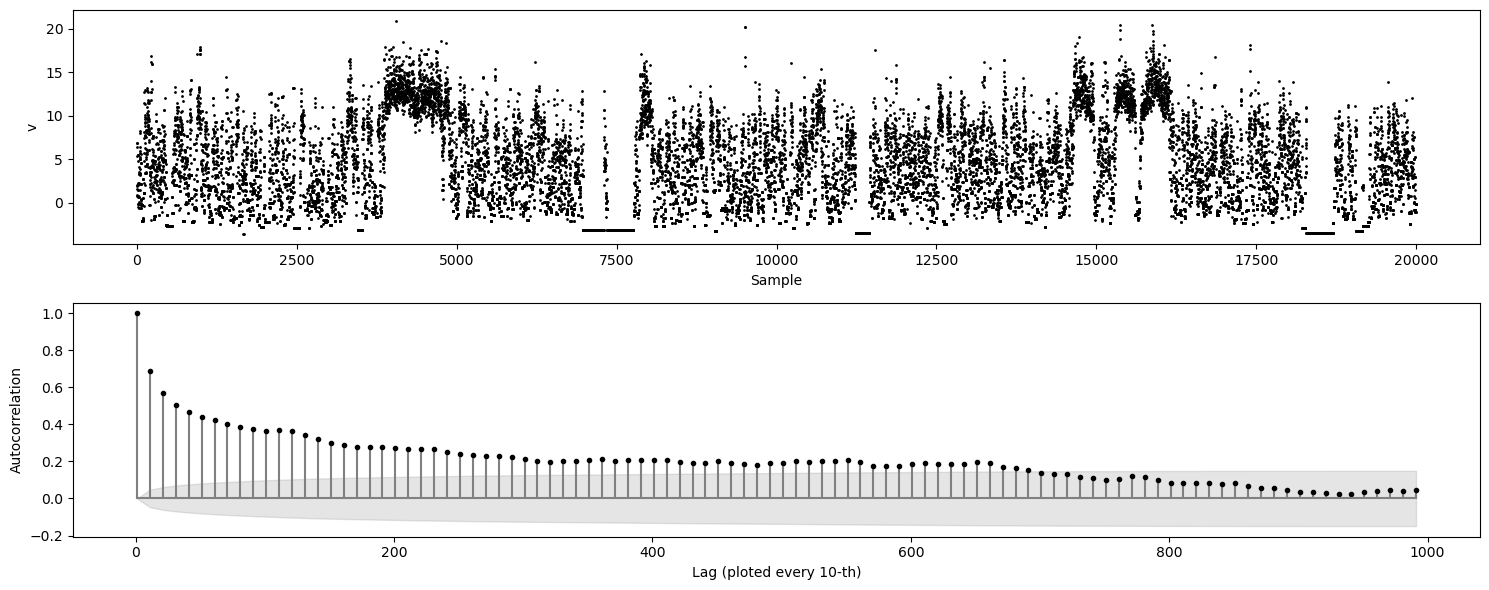

In [4]:
mean, ci = compute_CI(m1hmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(m1hmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), m1hmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(m1hmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()

Final step size: 0.5374993085861206
Final average acceptance rate: 0.580194800967262


(-10.0, 150.0)

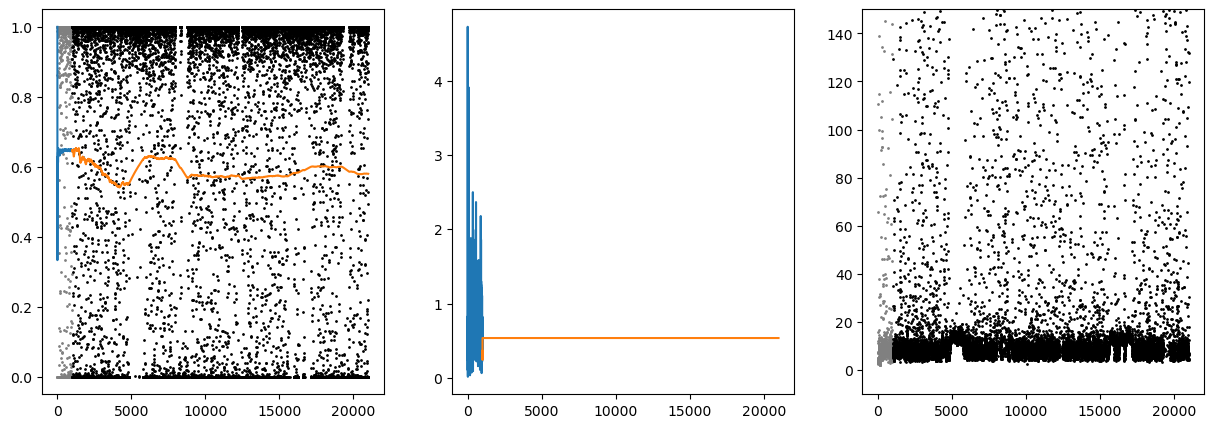

In [5]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m1hmc_states[i])) for i, arr in enumerate(burned_m1hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")



fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')

x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')
axes[2].set_ylim(-10,150)

### M=10

In [6]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m10hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, M=2)

carry, burned_m10hmc_states = jax.lax.scan(m10hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m10hmc_states = jax.lax.scan(m10hmc_kernel, carry, keys[num_warmup:,:])

Mean: 11.407339096069336+/- -0.06755426526069641
ESS: 29.294450759887695


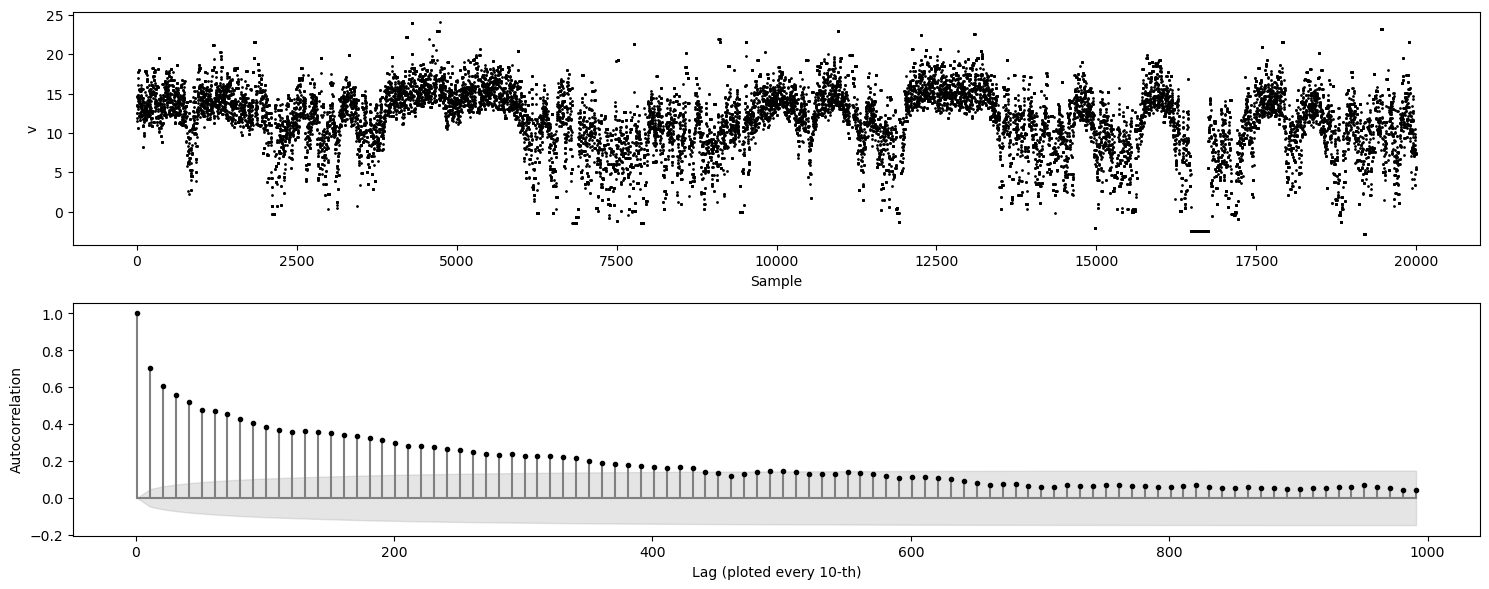

In [7]:
mean, ci = compute_CI(m10hmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(m10hmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), m10hmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(m10hmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()

Final step size: 1.2064121961593628
Final average acceptance rate: 0.5766566220238095


(-10.0, 150.0)

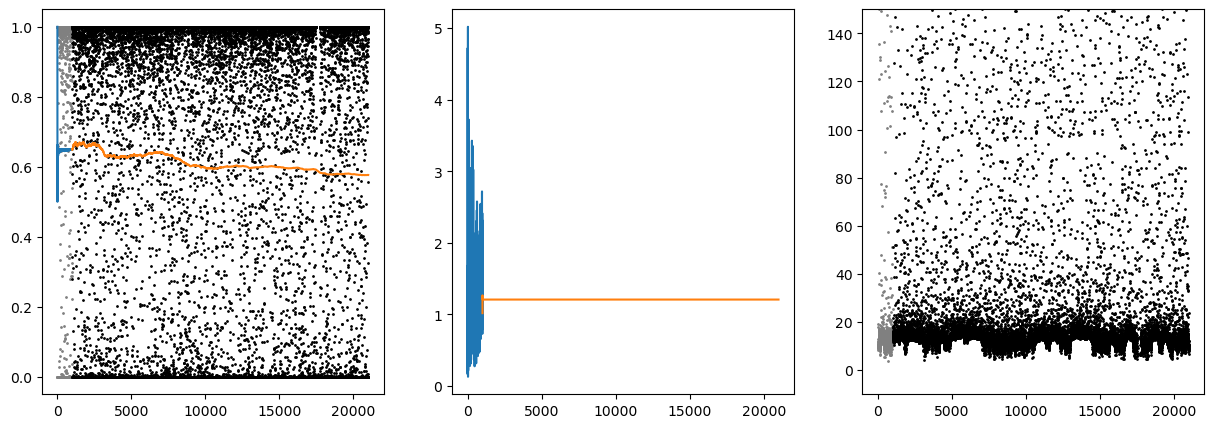

In [8]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m10hmc_states[i])) for i, arr in enumerate(burned_m10hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### M=0.1

In [9]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.25

init_state, m01hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, M=.5)

carry, burned_m01hmc_states = jax.lax.scan(m01hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m01hmc_states = jax.lax.scan(m01hmc_kernel, carry, keys[num_warmup:,:])

Mean: -4.261271953582764+/- -0.031348928809165955
ESS: 1.3583859205245972


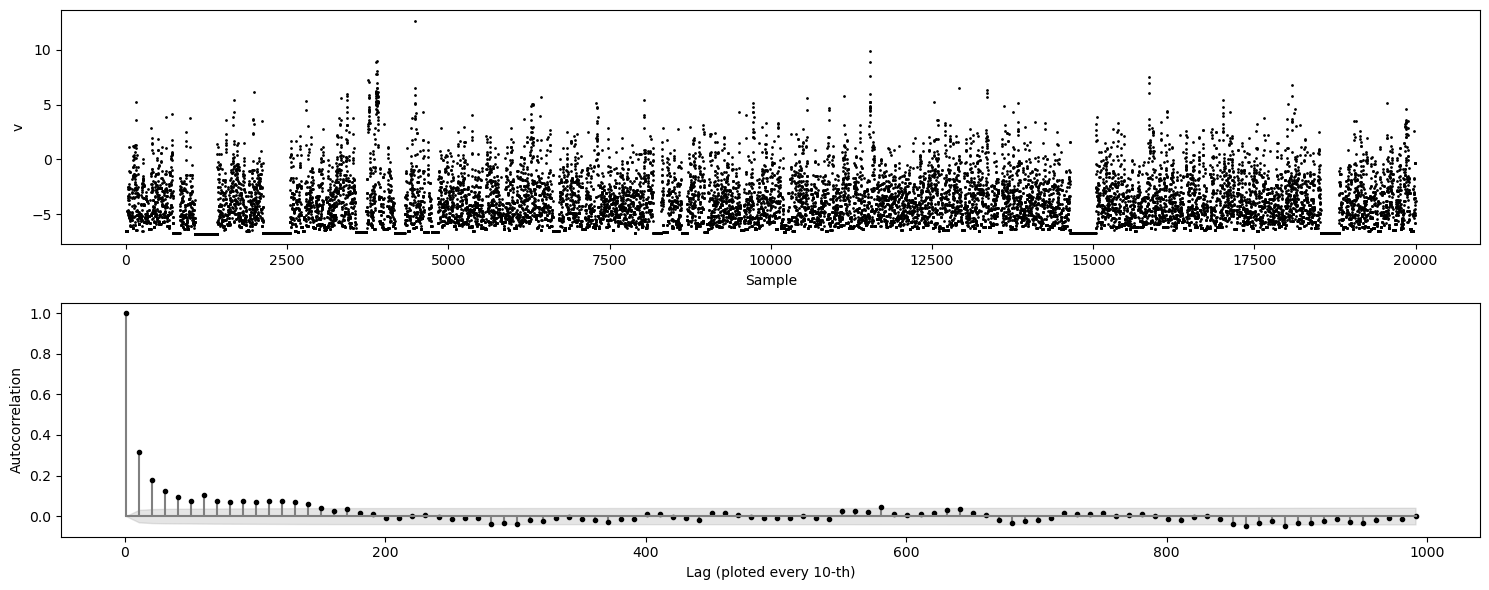

In [10]:
mean, ci = compute_CI(m01hmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(m01hmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), m01hmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(m01hmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()


Final step size: 0.06571786850690842
Final average acceptance rate: 0.5121884300595239


(-10.0, 150.0)

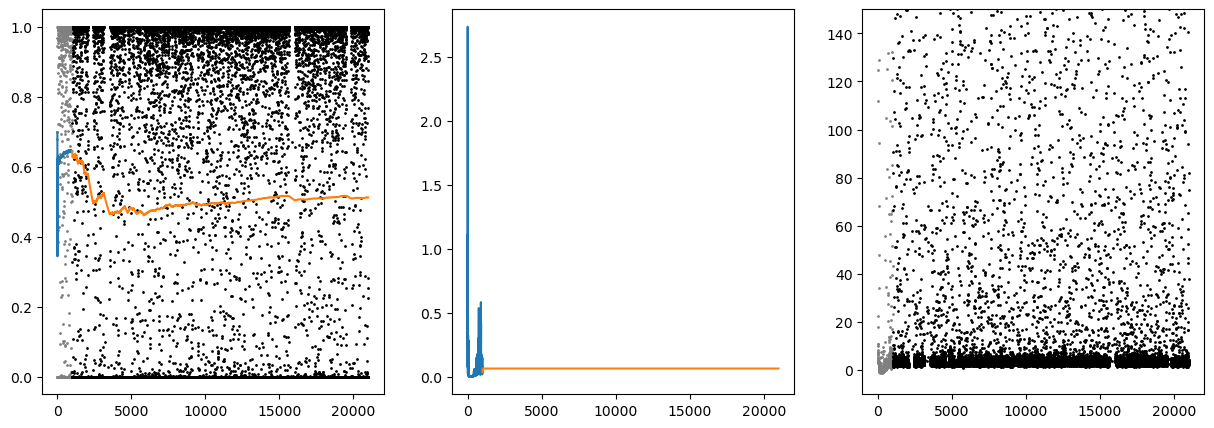

In [11]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, m01hmc_states[i])) for i, arr in enumerate(burned_m01hmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### DiagQHMC

In [12]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# random_mass_kwargs = {"mu":-.5, "sigma":.2}
random_mass_kwargs = {"mu":-.1, "sigma":.3} # this has rouhgly mean 1.0
# dual_avg_kwargs = None
init_step_size=.25

init_state, dqhmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, random_mass_kwargs=random_mass_kwargs)

carry, burned_dqhmc_states = jax.lax.scan(dqhmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , dqhmc_states = jax.lax.scan(dqhmc_kernel, carry, keys[num_warmup:,:])

Mean: 2.001155376434326+/- -0.062054336071014404
ESS: 441.7984924316406


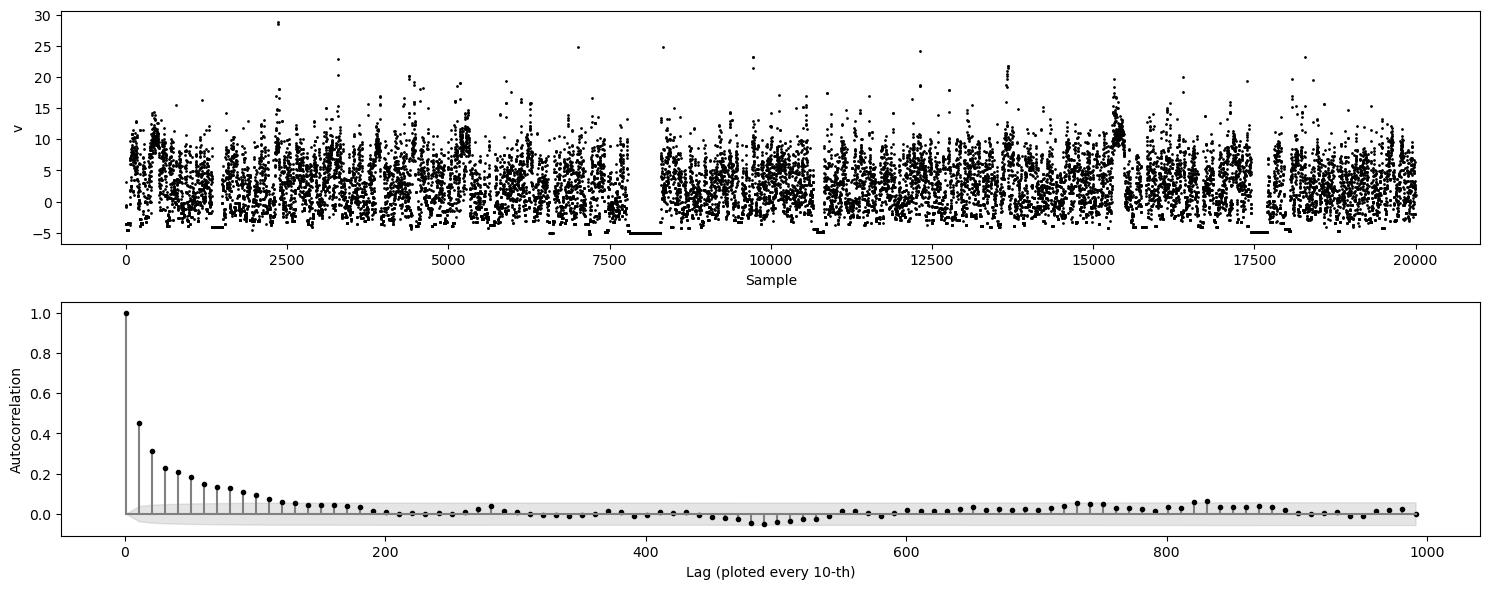

In [13]:
mean, ci = compute_CI(dqhmc_states[0][:,-1], .05)
print(f"Mean: {mean}+/- {ci}")
print(f"ESS: {effective_sample_size(dqhmc_states[0].T)}")

fig, ax = plt.subplots(2,1, figsize=(15,6))
ax[0].scatter(np.arange(num_samples), dqhmc_states[0][:,-1], s=1, c='k')
ax[0].set_ylabel("v")
ax[0].set_xlabel("Sample")
plot_ac(dqhmc_states[0][:,-1], lag=1000, plot_every=10, ax=ax[1])
plt.tight_layout()


Final step size: 0.27981963753700256
Final average acceptance rate: 0.6325073009672619


(-10.0, 150.0)

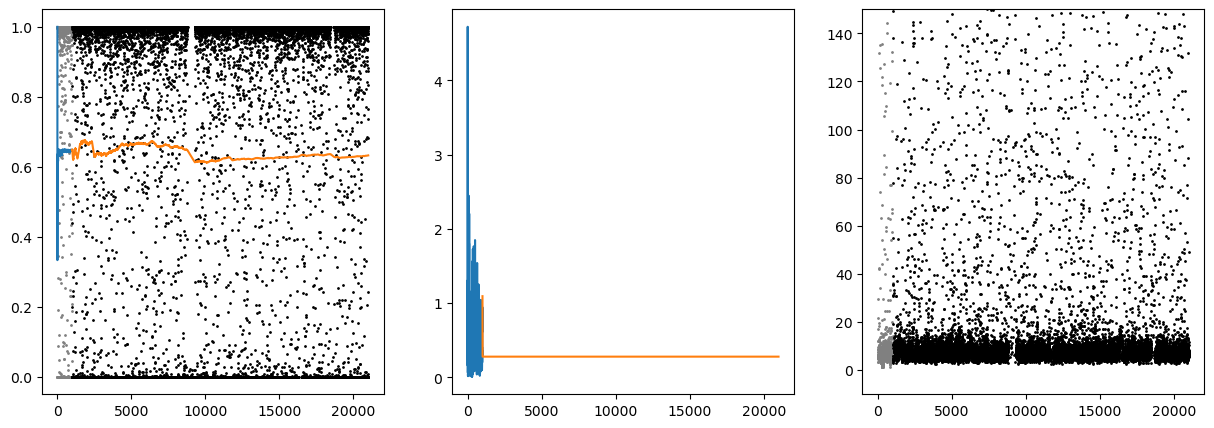

In [14]:
q, accept_prob, E_new, step_size = [np.concatenate((arr, dqhmc_states[i])) for i, arr in enumerate(burned_dqhmc_states)]
print(f"Final step size: {step_size[-1]}")

running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

fig, axes = plt.subplots(1,3, figsize=(15,5))
x = np.arange(num_warmup)

axes[0].plot(x, running_avg_a_rate[:num_warmup])
axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
axes[1].plot(x, step_size[:num_warmup])
axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


x = np.arange(num_warmup, num_samples+num_warmup)
axes[0].plot(x, running_avg_a_rate[num_warmup:])
axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
axes[1].plot(x, step_size[num_warmup:])
axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

axes[2].set_ylim(-10,150)

### Result comparison

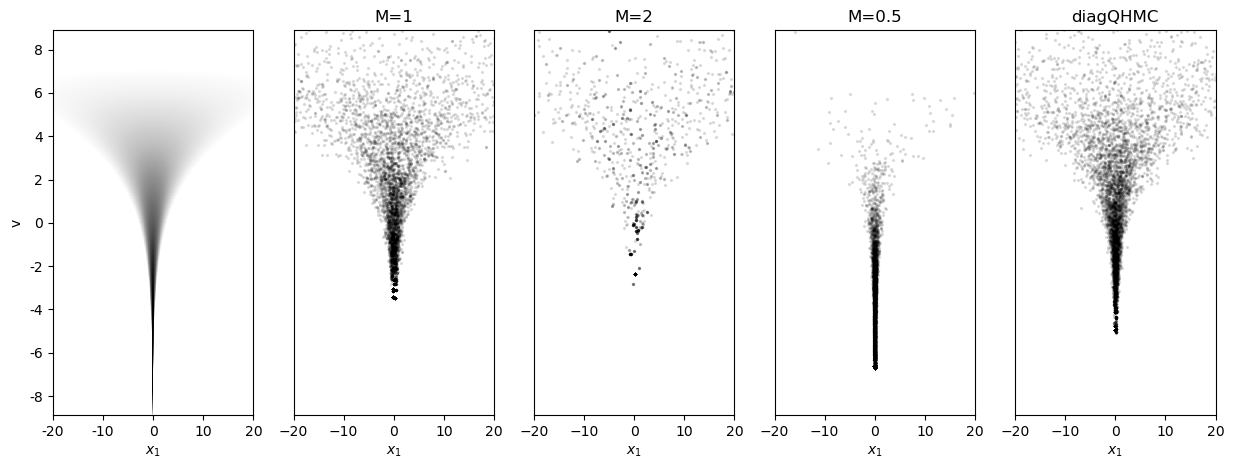

In [15]:
x_lim = [-20, 20]
y_lim = [-9, 9]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(1,5, figsize=(15,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp[:,:-2], vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax[0].set_xticks(np.linspace(0,res,len(x_labels)))
ax[0].set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax[0].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[0].set_yticklabels(y_labels)
ax[0].set_ylabel("v")
ax[0].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

ax[1].set_title("M=1")
ax[1].scatter(*m1hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[2].set_title("M=2")
ax[2].scatter(*m10hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[3].set_title("M=0.5")
ax[3].scatter(*m01hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[4].set_title("diagQHMC")
ax[4].scatter(*dqhmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

for i in range(1,5):
    ax[i].set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian
    ax[i].set_xlim(*x_lim)
    ax[i].set_ylim(*y_lim)
    ax[i].set_yticks([])